In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy import io

In [2]:
# 난수 생성을 위한 seed 값 설정
np.random.seed(0)
# data 파일 읽기
input_mat = io.loadmat('data/SonarAlt.mat')

In [3]:
# 분석할 값만 배열로 저장
def get_sonar(i):
    """Measure sonar."""
    z = input_mat['sonarAlt'][0][i]  # input_mat['sonaralt']: (1, 1501)
    return z

In [4]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm."""
    """칼만필터 알고리즘 (매개변수: 측정값, 추정값, 오차공분산)"""
    
    # (1) Prediction.
    """x와 P의 계산
    Input: 직전추정값과 오차공분산
    OutputL 예측값 """
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q 

    # (2) Kalman Gain.
    """Kalman Gain 계산 
        P는 (1)에서 계산
        H와 R은 미리 설정된 값"""
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    """입력된 측정값으로 추정값 계산
        X_pred는 (1)에서 계산"""
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    """오차공분산 구하기
        앞에서 계산한 추정값을 사용할지 말지를 결정"""
    P = P_pred - K @ H @ P_pred

    #  추정값과 오차공분산
    return x_esti, P 

In [5]:
# Input parameters.
n_samples = 500
time_end = 10

In [6]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
dt = time_end / n_samples
"""시스템 모델: A, H, Q, R
    칼만필터를 사용하는 목적에 따라 사용자가 정함"""
A = np.array([[1, dt],
              [0, 1]])
H = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 3]])
R = np.array([[10]])


In [7]:
# 초깃값 설정 및 선언
x_0 = np.array([0, 20])  # position and velocity
P_0 = 5 * np.eye(2)
time = np.arange(0, time_end, dt)
z_pos_meas_save = np.zeros(n_samples)
z_vel_meas_save = np.zeros(n_samples)
x_pos_esti_save = np.zeros(n_samples)
x_vel_esti_save = np.zeros(n_samples)
x_esti, P = None, None

In [8]:
# Kalman Filter 수행 
for i in range(n_samples):
    z_meas = get_sonar(i) # z_meas: 측정값
    # (0) Initialization for estimation.
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    z_pos_meas_save[i] = z_meas
    x_pos_esti_save[i] = x_esti[0]
    x_vel_esti_save[i] = x_esti[1]

In [9]:
# 칼만필터 적용 전 속도 구하기
for i in range(len(z_pos_meas_save)):
    # 속도 = 변위 /시간
    z_vel_meas_save[i] = (z_pos_meas_save[i]-z_pos_meas_save[i-1])/dt
    

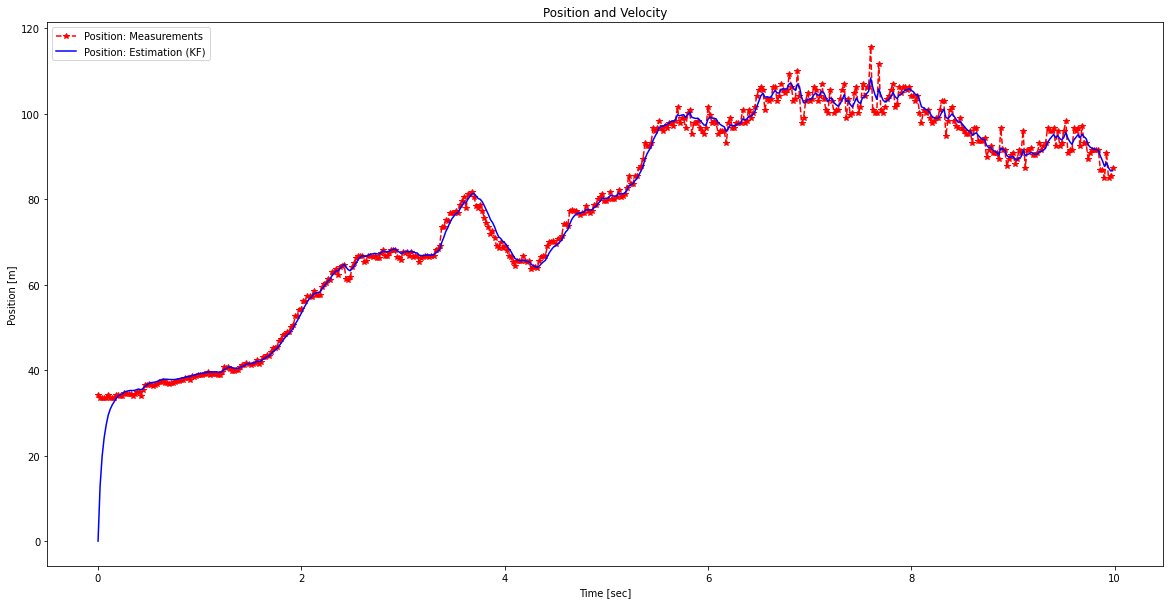

In [10]:
# 위치 측정 그래프 그리기
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.plot(time, z_pos_meas_save, 'r*--', label='Position: Measurements')
plt.plot(time, x_pos_esti_save, 'b-', label='Position: Estimation (KF)')
plt.legend(loc='upper left')
plt.title('Position and Velocity')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')
plt.savefig('sonar_pos&vel_kf.png') # 그래프 저장

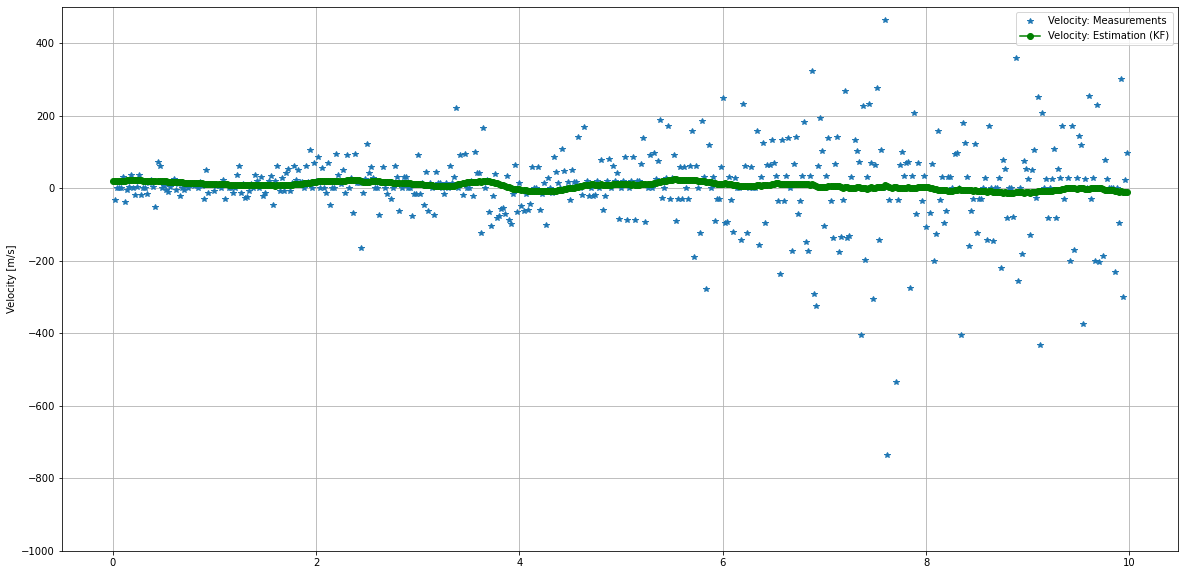

In [11]:
# 속도(Velocity) 그래프 그리기
fig, ax2 = plt.subplots(figsize=(20, 10))
plt.ylim(-1000,500)
plt.plot(time, z_vel_meas_save, '*', label='Velocity: Measurements')
plt.plot(time, x_vel_esti_save, 'go-', label='Velocity: Estimation (KF)')
plt.legend(loc='upper right')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.savefig('sonar_pos2vel_kf.png') # 그래프 저장